## 📦 Dataset

This project uses and transforms the Kaggle dataset:

**Source**: [Sephora Products and Skincare Reviews by nadyinky](https://www.kaggle.com/datasets/nadyinky/sephora-products-and-skincare-reviews)  
**License**: [Creative Commons Attribution 4.0 (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/)  



In [3]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler


In [5]:
reviews_0_250 = pd.read_csv(r"F:\My_CSV_\final_test_1\reviews_0-250.csv", low_memory=False)
reviews_250_500 = pd.read_csv(r"F:\My_CSV_\final_test_1\reviews_250-500.csv", low_memory=False)
reviews_500_750 = pd.read_csv(r"F:\My_CSV_\final_test_1\reviews_500-750.csv", low_memory=False)
reviews_750_1250 = pd.read_csv(r"F:\My_CSV_\final_test_1\reviews_750-1250.csv", low_memory=False)
reviews_1250_end = pd.read_csv(r"F:\My_CSV_\final_test_1\reviews_1250-end.csv", low_memory=False)

In [6]:
reviews_0_250_c = reviews_0_250.copy()
reviews_250_500_c =reviews_250_500.copy()
reviews_500_750_c =reviews_500_750.copy()
reviews_750_1250_c = reviews_750_1250.copy()
reviews_1250_end_C =reviews_1250_end.copy()


In [7]:
def clean_and_preprocess_reviews(df):
    import re

    # Step 1: Drop irrelevant columns
    columns_to_drop_initial = [
        'Unnamed: 0', 'submission_time', 'total_feedback_count',
        'total_pos_feedback_count', 'total_neg_feedback_count',
        'product_name', 'author_id', 'helpfulness', 'is_recommended',
        'brand_name', 'price_usd', 'product_id',
        # Drop weak or noisy features
        'eye_color', 'hair_color'
    ]
    df = df.drop(columns=columns_to_drop_initial, errors='ignore')

    # Step 2: Fill missing review_title and review_text
    df['review_title'] = df['review_title'].fillna('')
    df['review_text'] = df['review_text'].fillna('')

    # Step 3: Combine into full_review
    df['full_review'] = df['review_title'] + ' ' + df['review_text']

    # Step 4: Remove empty full_review rows
    df = df[df['full_review'].str.strip() != '']

    # Step 5: Drop original title/text
    df = df.drop(columns=['review_title', 'review_text'], errors='ignore')

    # Step 6: Clean full_review text
    def clean_text_bert(text):
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    df['full_review'] = df['full_review'].apply(clean_text_bert)

    # 🔥 Step 7: Drop duplicate full_review texts
    df = df.drop_duplicates(subset='full_review')

    return df


reviews_0_250_c = clean_and_preprocess_reviews(reviews_0_250.copy())
reviews_250_500_c = clean_and_preprocess_reviews(reviews_250_500.copy())
reviews_500_750_c = clean_and_preprocess_reviews(reviews_500_750.copy())
reviews_750_1250_c = clean_and_preprocess_reviews(reviews_750_1250.copy())
reviews_1250_end_C = clean_and_preprocess_reviews(reviews_1250_end.copy())


In [8]:
reviews_0_250_clean = reviews_0_250_c.copy()
reviews_250_500_clean =reviews_250_500_c.copy()
reviews_500_750_clean =reviews_500_750_c.copy()
reviews_750_1250_clean = reviews_750_1250_c.copy()
reviews_1250_end_Clean =reviews_1250_end_C.copy()

In [9]:
reviews_1250_end_Clean.columns

Index(['rating', 'skin_tone', 'skin_type', 'full_review'], dtype='object')

In [10]:
reviews_0_250_clean['rating'].value_counts(normalize = True)


rating
5    0.647861
4    0.179115
3    0.071509
1    0.053720
2    0.047795
Name: proportion, dtype: float64

In [11]:
import pandas as pd
import warnings

# Suppress the specific DeprecationWarning about groupby.apply
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message="DataFrameGroupBy.apply operated on the grouping columns"
)

# Sample 2000 reviews from each DataFrame (with random_state for reproducibility)
sample_0_250 = reviews_0_250_clean.sample(n=20000, random_state=42)
sample_250_500 = reviews_250_500_clean.sample(n=20000, random_state=42)
sample_500_750 = reviews_500_750_clean.sample(n=20000, random_state=42)
sample_750_1250 = reviews_750_1250_clean.sample(n=20000, random_state=42)
sample_1250_end = reviews_1250_end_Clean.sample(n=20000, random_state=42)

# Combine all cleaned datasets
all_reviews = pd.concat([
    reviews_0_250_clean,
    reviews_250_500_clean,
    reviews_500_750_clean,
    reviews_750_1250_clean,
    reviews_1250_end_Clean
], ignore_index=True)

def sample_with_rating(df):
    sampled = df.sample(n=min(len(df), 20000), random_state=42)
    sampled['rating'] = df.name  # df.name is the group key (rating)
    return sampled

stratified_sample = (
    all_reviews
    .groupby('rating', group_keys=False)
    .apply(sample_with_rating)  # warning suppressed above, no changes here
    .reset_index(drop=True)
)

# Verify results
print("Final balanced dataset shape:", stratified_sample.shape)
print("\nPerfect class distribution:")
print(stratified_sample['rating'].value_counts(normalize=True))


Final balanced dataset shape: (100000, 4)

Perfect class distribution:
rating
1    0.2
2    0.2
3    0.2
4    0.2
5    0.2
Name: proportion, dtype: float64


In [12]:
X = stratified_sample


In [13]:
y = X.pop('rating')
#y.unique()

In [14]:
y = y -1

In [15]:
y.unique()

array([0, 1, 2, 3, 4])

In [16]:
y.value_counts(normalize = True)

rating
0    0.2
1    0.2
2    0.2
3    0.2
4    0.2
Name: proportion, dtype: float64

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Correct text pipeline - remove 'sparse' parameter
text_pipe = make_pipeline(
    TfidfVectorizer(
        max_features=5000,       # Increased from 100
        stop_words='english',
        ngram_range=(1, 2),      # Using both unigrams and bigrams
        min_df=5,                # Ignore terms appearing in <5 docs
        max_df=0.7               # Ignore terms in >70% of docs
    )
    # No sparse parameter needed - it's always sparse by default
)

# Categorical pipeline
cat_pipe = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='N_A'),
    OneHotEncoder(handle_unknown='ignore', sparse_output=True)  # Correct parameter name
)

# Combine pipelines
preprocessor = make_column_transformer(
    (cat_pipe, ['skin_type', 'skin_tone']),  # Example categorical columns
    (text_pipe, "full_review"),             # Text column
    remainder='drop'
)

In [22]:
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='N_A',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['skin_type', 'skin_tone']),
                                ('pipeline-2',
                                 Pipeline(steps=[('tfidfvectorizer',
                                                  TfidfVectorizer(max_df=0.7,
                                                                  max_features=5000,
                                                                  min_df=5,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'))]),
                                 'full_review')])

In [23]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


In [18]:
'''
import joblib
joblib.dump(preprocessor, "preprocessor.pkl")
'''

['preprocessor.pkl']

In [24]:
X_train_transformed.shape

(80000, 5019)

## Dimensionality Reduction and Data Preparation for Deep Learning
To prepare the data for deep learning, we first split the transformed features into structured (categorical) and text (TF-IDF) parts. We then applied TruncatedSVD to reduce the dimensionality of the high-dimensional TF-IDF text features, improving efficiency and preventing memory issues. Finally, we combined the reduced text features with the structured features and converted the result into TensorFlow tensors for model training.



In [25]:

from sklearn.decomposition import TruncatedSVD
# 2. Split the transformed matrix into structured (categorical) and text (TF-IDF) parts
# First, determine how many one-hot encoded features were created by the categorical pipeline
n_cat = len(preprocessor.named_transformers_['pipeline-1'].named_steps['onehotencoder'].get_feature_names_out())

# Use slicing to separate the one-hot features (structured) and TF-IDF features (text)
X_train_struct = X_train_transformed[:, :n_cat]  # Structured part (e.g., skin_type, skin_tone)
X_train_text = X_train_transformed[:, n_cat:]    # Text part (e.g., full_review TF-IDF)

X_test_struct = X_test_transformed[:, :n_cat]
X_test_text = X_test_transformed[:, n_cat:]

# 3. Apply TruncatedSVD to reduce dimensionality of the text part (TF-IDF vectors)
# This helps prevent memory errors and speeds up training
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_text_reduced = svd.fit_transform(X_train_text)  # Fit on train text
X_test_text_reduced = svd.transform(X_test_text)        # Transform test text using same SVD

# 4. Combine structured features and reduced text features into one dense matrix
# Convert structured (sparse) part to dense using .toarray(), then horizontally stack
X_train_combined = np.hstack((X_train_struct.toarray(), X_train_text_reduced))
X_test_combined = np.hstack((X_test_struct.toarray(), X_test_text_reduced))

# 5. Convert the combined NumPy arrays to TensorFlow tensors for model training
X_train_tensor = tf.convert_to_tensor(X_train_combined, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test_combined, dtype=tf.float32)

y_train_tensor = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test.values, dtype=tf.float32)


In [21]:
#joblib.dump(svd, "svd.pkl")


['svd.pkl']

In [26]:
print(X_train_tensor.shape)


(80000, 319)


## Deep Learning Experiments and Overfitting Prevention
In this section, we revisited both classification and regression problems by testing various deep learning models. We experimented with different numbers of neurons and adjusted hyperparameters to optimize performance. Additionally, we explored multiple strategies to prevent overfitting and identify the most effective approach for our data.



## Deep Classification Network _ 1

In [24]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(319,)),  # Use 5018 features as input shape
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(X_train_tensor, y_train_tensor, epochs=20, validation_split=0.2)


Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.3744 - loss: 1.3865 - val_accuracy: 0.5261 - val_loss: 1.0828
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5366 - loss: 1.0643 - val_accuracy: 0.5338 - val_loss: 1.0700
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5446 - loss: 1.0488 - val_accuracy: 0.5318 - val_loss: 1.0760
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5483 - loss: 1.0335 - val_accuracy: 0.5359 - val_loss: 1.0655
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5592 - loss: 1.0186 - val_accuracy: 0.5359 - val_loss: 1.0628
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5611 - loss: 1.0119 - val_accuracy: 0.5369 - val_loss: 1.0686
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5637 - loss: 1.0060 - val_accuracy: 0.5328 - val_loss: 1.0668
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5702 - loss: 0.9979 

In [25]:
import pandas as pd

# Convert to DataFrame
df = pd.DataFrame(history.history)
df.index += 1  # Start index at 1 for epoch numbering

# Print all epochs in tabular form
#print(df[['loss', 'val_loss', 'mae', 'val_mae']])
df.head()

,accuracy,loss,val_accuracy,val_loss
1,0.459812,1.220854,0.526062,1.082752
2,0.533906,1.067742,0.533813,1.070027
3,0.543156,1.048659,0.531812,1.075961
4,0.548594,1.036705,0.535937,1.065500
5,0.553688,1.027242,0.535937,1.062817


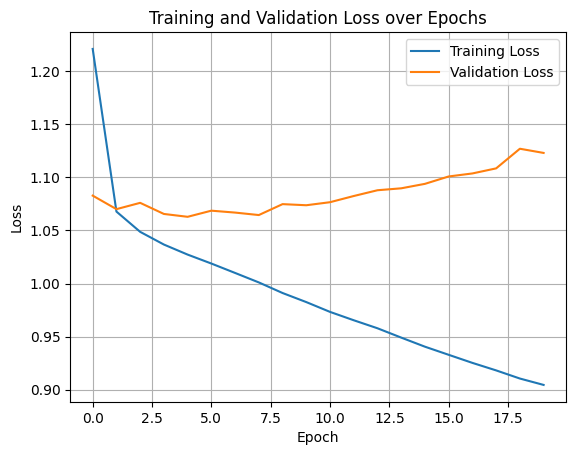

In [26]:
import matplotlib.pyplot as plt

def plot_loss(history):
    # Plot training loss (error on training data over epochs)
    plt.plot(history.history['loss'], label='Training Loss')
    # Plot validation loss (error on validation data over epochs)
    plt.plot(history.history['val_loss'], label='Validation Loss')
    
    plt.xlabel('Epoch')               # X-axis: epochs (iterations over dataset)
    plt.ylabel('Loss')                # Y-axis: loss value (error metric)
    
    plt.legend()                     # Show legend to distinguish lines
    plt.grid(True)                   # Show grid for easier reading
    plt.title('Training and Validation Loss over Epochs')
    plt.show()

# Call the function to display the plot
plot_loss(history)


In [27]:
# 1. Apply preprocessor (already correct)
X_test_transformed = preprocessor.transform(X_test)

# 2. Separate structured and text parts
n_cat = len(preprocessor.named_transformers_['pipeline-1'].named_steps['onehotencoder'].get_feature_names_out())
X_test_struct = X_test_transformed[:, :n_cat]
X_test_text = X_test_transformed[:, n_cat:]

# 3. Apply the same SVD that was fit on training text
X_test_text_reduced = svd.transform(X_test_text)

# 4. Combine
X_test_combined = np.hstack((X_test_struct.toarray(), X_test_text_reduced))

# 5. Convert to tensor
X_test_tensor = tf.convert_to_tensor(X_test_combined, dtype=tf.float32)

# 6. Predict
predictions_proba = model.predict(X_test_tensor)
predictions = predictions_proba.argmax(axis=1)

# 7. Evaluate
accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy:", accuracy)


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Test Accuracy: 0.52635


## Deep Classification Network _ 2

In [30]:
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

model = tf.keras.Sequential([
    layers.Input(shape=(X_train_tensor.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_tensor, y_train_tensor,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stop]
)


Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.3188 - loss: 1.6260 - val_accuracy: 0.5266 - val_loss: 1.0850
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4952 - loss: 1.1486 - val_accuracy: 0.5294 - val_loss: 1.0671
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5155 - loss: 1.1193 - val_accuracy: 0.5344 - val_loss: 1.0615
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5258 - loss: 1.1015 - val_accuracy: 0.5403 - val_loss: 1.0544
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5256 - loss: 1.0938 - val_accuracy: 0.5387 - val_loss: 1.0497
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5325 - loss: 1.0864 - val_accuracy: 0.5440 - val_loss: 1.0494
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5392 - loss: 1.0692 - val_accuracy: 0.5429 - val_loss: 1.0525
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5354 - loss: 1.0755 - 

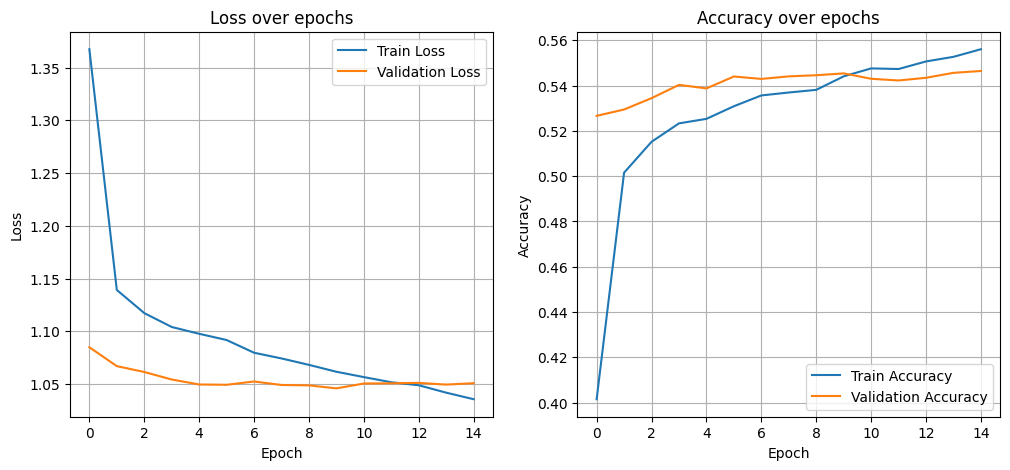

In [31]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot loss
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()
    plt.grid(True)

    plt.show()

# Call the function with your history object
plot_training_history(history)


In [32]:
# 1. Apply preprocessor (already correct)
X_test_transformed = preprocessor.transform(X_test)

# 2. Separate structured and text parts
n_cat = len(preprocessor.named_transformers_['pipeline-1'].named_steps['onehotencoder'].get_feature_names_out())
X_test_struct = X_test_transformed[:, :n_cat]
X_test_text = X_test_transformed[:, n_cat:]

# 3. Apply the same SVD that was fit on training text
X_test_text_reduced = svd.transform(X_test_text)

# 4. Combine
X_test_combined = np.hstack((X_test_struct.toarray(), X_test_text_reduced))

# 5. Convert to tensor
X_test_tensor = tf.convert_to_tensor(X_test_combined, dtype=tf.float32)

# 6. Predict
predictions_proba = model.predict(X_test_tensor)
predictions = predictions_proba.argmax(axis=1)

# 7. Evaluate
accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy:", accuracy)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Test Accuracy: 0.54295


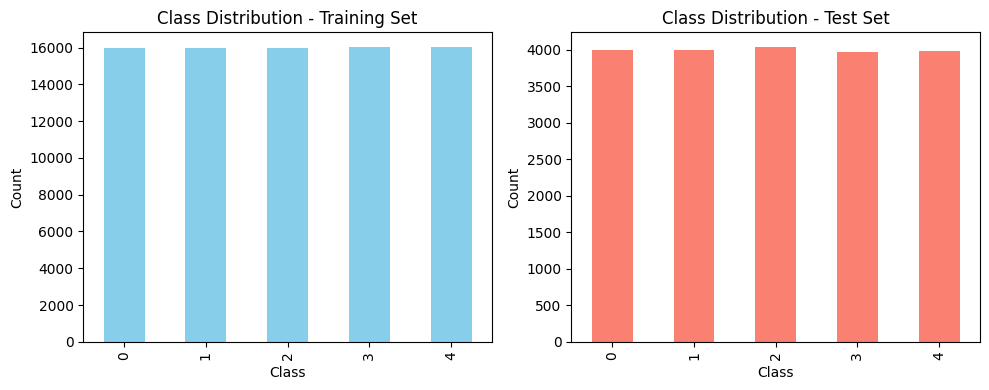

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Count class occurrences
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()

# Plot class distribution for training set
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
train_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution - Training Set')
plt.xlabel('Class')
plt.ylabel('Count')

# Plot class distribution for test set
plt.subplot(1, 2, 2)
test_counts.plot(kind='bar', color='salmon')
plt.title('Class Distribution - Test Set')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


## Deep Regression Network_1

In [34]:
from tensorflow.keras import layers, models, callbacks, optimizers

model = models.Sequential([
    layers.Input(shape=(X_train_tensor.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='linear')  # Regression output
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = model.fit(
    X_train_tensor, y_train_tensor,
    epochs=50,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 2.7435 - root_mean_squared_error: 1.6164 - val_loss: 0.8354 - val_root_mean_squared_error: 0.9140
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9733 - root_mean_squared_error: 0.9865 - val_loss: 0.7719 - val_root_mean_squared_error: 0.8786
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8709 - root_mean_squared_error: 0.9332 - val_loss: 0.7377 - val_root_mean_squared_error: 0.8589
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8175 - root_mean_squared_error: 0.9042 - val_loss: 0.7313 - val_root_mean_squared_error: 0.8552
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7979 - root_mean_squared_error: 0.8932 - val_loss: 0.7247 - val_root_mean_squared_error: 0.8513
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7706 - root_mean_squared_error: 0.8778 - val_loss: 0.7186 - val_root_mean_squared_error: 0.8477
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━

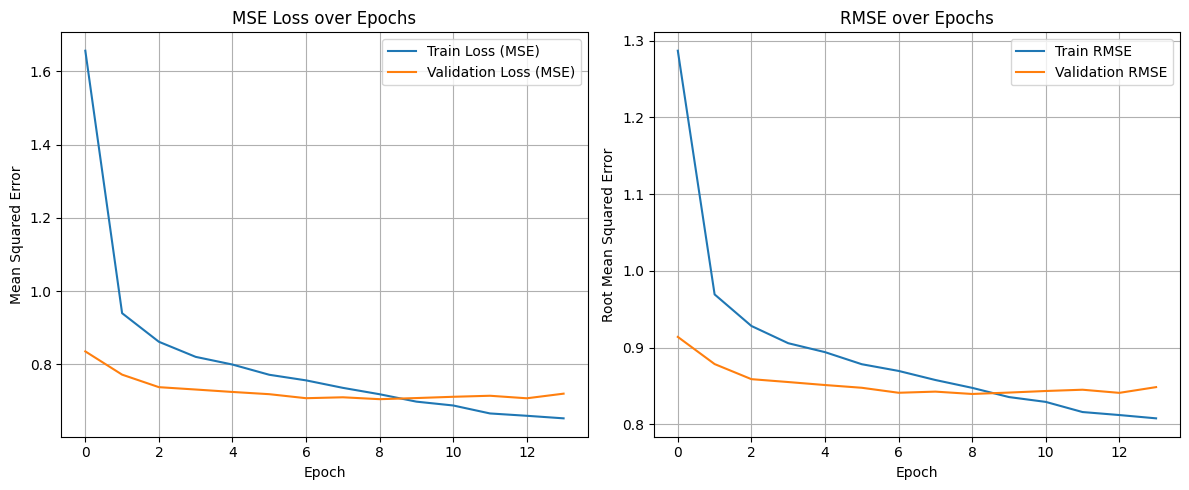

In [35]:
import matplotlib.pyplot as plt

def plot_regression_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot training and validation MSE loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.title('MSE Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Plot training and validation RMSE if tracked
    if 'root_mean_squared_error' in history.history and 'val_root_mean_squared_error' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
        plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
        plt.xlabel('Epoch')
        plt.ylabel('Root Mean Squared Error')
        plt.title('RMSE over Epochs')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Use this function by passing the history object from model.fit()
plot_regression_training_history(history)


In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. Apply preprocessor on X_test (already done earlier, just for clarity)
X_test_transformed = preprocessor.transform(X_test)

# 2. Separate structured (one-hot) and text (TF-IDF) parts
n_cat = len(preprocessor.named_transformers_['pipeline-1'].named_steps['onehotencoder'].get_feature_names_out())
X_test_struct = X_test_transformed[:, :n_cat]
X_test_text = X_test_transformed[:, n_cat:]

# 3. Apply SVD on text part using the fitted svd from training
X_test_text_reduced = svd.transform(X_test_text)

# 4. Combine structured and text features (convert sparse to dense)
X_test_combined = np.hstack((X_test_struct.toarray(), X_test_text_reduced))

# 5. Convert combined features to tensor
X_test_tensor = tf.convert_to_tensor(X_test_combined, dtype=tf.float32)

# 6. Predict using the regression model
y_pred = model.predict(X_test_tensor).flatten()  # flatten to 1D array

# 7. Convert true labels tensor to numpy array
y_true = y_test_tensor.numpy().flatten()

# 8. Calculate regression metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R² Score: {r2:.4f}")


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
Test RMSE: 0.8439
Test MAE: 0.6514
Test R² Score: 0.6434


## Deep Regression Network_2

In [37]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model = tf.keras.Sequential([
    layers.Input(shape=(X_train_tensor.shape[1],)),  # Input layer sized to match feature dimensions
    
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # 32-neuron hidden layer with ReLU
    layers.BatchNormalization(),  # Normalizes activations to stabilize training
    layers.Dropout(0.4),  # Randomly drops 40% of neurons to prevent overfitting
    
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Smaller 16-neuron hidden layer
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    layers.Dense(1)  # Single output neuron for regression (rating prediction)
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adam optimizer with standard learning rate

model.compile(
    optimizer=optimizer,
    loss='mse',  # Mean Squared Error for regression
    metrics=[tf.keras.metrics.RootMeanSquaredError()]  # Tracks RMSE during training
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Stops training if no improvement for 3 epochs

# Train the model
history = model.fit(
    X_train_tensor, y_train_tensor,
    validation_split=0.2,  # Uses 20% of training data for validation
    epochs=50,  # Maximum training epochs
    batch_size=32,  # Number of samples per gradient update
    callbacks=[early_stop],  # Uses early stopping
    verbose=1  # Shows progress bar
)


Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 3.9857 - root_mean_squared_error: 1.9360 - val_loss: 0.9501 - val_root_mean_squared_error: 0.9341
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.1937 - root_mean_squared_error: 1.0576 - val_loss: 0.8769 - val_root_mean_squared_error: 0.9011
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.0475 - root_mean_squared_error: 0.9931 - val_loss: 0.8082 - val_root_mean_squared_error: 0.8702
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9815 - root_mean_squared_error: 0.9656 - val_loss: 0.7896 - val_root_mean_squared_error: 0.8626
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.9420 - root_mean_squared_error: 0.9470 - val_loss: 0.7965 - val_root_mean_squared_error: 0.8671
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.9377 - root_mean_squared_error: 0.9447 - val_loss: 0.7917 - val_root_mean_squared_error: 0.8637
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━

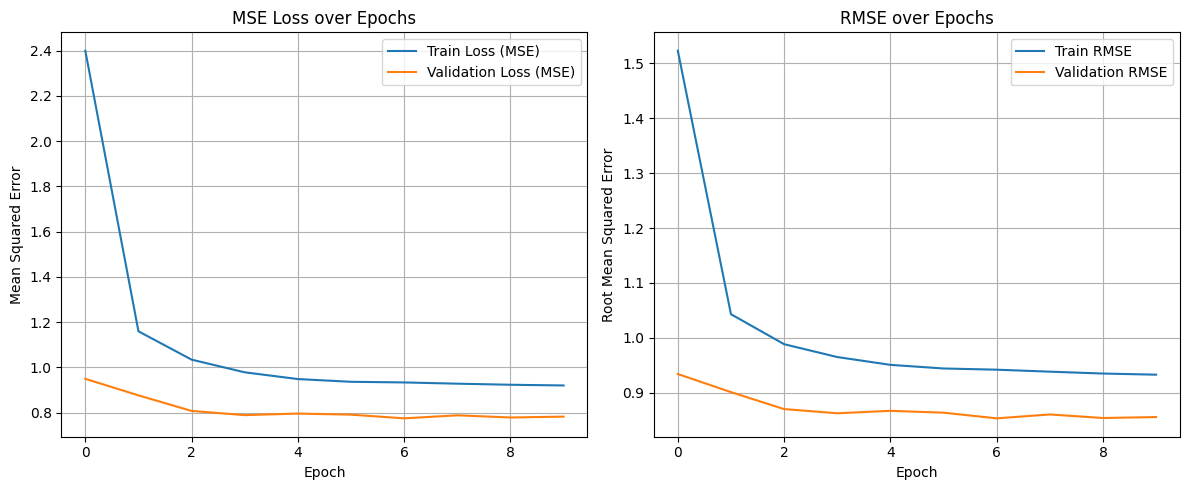

In [38]:
import matplotlib.pyplot as plt

def plot_regression_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot MSE loss (training and validation)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.title('MSE Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Plot RMSE metric (training and validation)
    if 'root_mean_squared_error' in history.history and 'val_root_mean_squared_error' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
        plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
        plt.xlabel('Epoch')
        plt.ylabel('Root Mean Squared Error')
        plt.title('RMSE over Epochs')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function with your history object from model.fit()
plot_regression_training_history(history)


In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import tensorflow as tf

# 1. Apply preprocessor on X_test (done earlier, repeating here for clarity)
X_test_transformed = preprocessor.transform(X_test)

# 2. Separate structured (one-hot encoded) and text (TF-IDF) parts
n_cat = len(preprocessor.named_transformers_['pipeline-1'].named_steps['onehotencoder'].get_feature_names_out())
X_test_struct = X_test_transformed[:, :n_cat]
X_test_text = X_test_transformed[:, n_cat:]

# 3. Apply the already fitted SVD on the test text features to reduce dimensionality
X_test_text_reduced = svd.transform(X_test_text)

# 4. Combine the structured features (converted to dense array) and reduced text features
X_test_combined = np.hstack((X_test_struct.toarray(), X_test_text_reduced))

# 5. Convert combined features to a TensorFlow tensor for model input
X_test_tensor = tf.convert_to_tensor(X_test_combined, dtype=tf.float32)

# 6. Use the trained model to predict continuous values (regression output)
y_pred = model.predict(X_test_tensor).flatten()  # Flatten to 1D array

# 7. Convert true target tensor to numpy array for metric calculations
y_true = y_test_tensor.numpy().flatten()

# 8. Compute regression metrics to evaluate model performance
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Test RMSE_2: {rmse:.4f}")
print(f"Test MAE_2: {mae:.4f}")
print(f"Test R²_2 Score: {r2:.4f}")


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 957us/step
Test RMSE_2: 0.8606
Test MAE_2: 0.6760
Test R²_2 Score: 0.6291


## Final Deep Learning Results and Insights
In the final phase of our deep learning experiments for regression, we successfully identified the optimal number of neurons that delivered the best predictive performance. To gain deeper insights into the training process, we incorporated TensorBoard, enabling clear and interactive visualization of model metrics. Our deep learning approach notably outperformed traditional machine learning models, showcasing its superior capacity and adaptability. Importantly, the deep learning models were trained on larger datasets, reflecting the advantage of deep learning in leveraging more data for improved results. Achieving a test RMSE of 0.8383, MAE of 0.6440, and an R² score of 0.6481 demonstrates promising performance given the use of TF-IDF for text representation; exploring advanced embeddings like BERT could further elevate model accuracy and robustness.

## Deep Regression Network_3

In [27]:
# Use the same steps, but add scaling for structured features:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

# After splitting structured and text features, scale structured features
scaler = StandardScaler()

X_train_struct_scaled = scaler.fit_transform(X_train_struct.toarray())
X_test_struct_scaled = scaler.transform(X_test_struct.toarray())

# Then combine with reduced text features
X_train_combined = np.hstack((X_train_struct_scaled, X_train_text_reduced))
X_test_combined = np.hstack((X_test_struct_scaled, X_test_text_reduced))

# Convert to tensors
X_train_tensor = tf.convert_to_tensor(X_train_combined, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test_combined, dtype=tf.float32)


In [28]:
from tensorflow.keras import models, layers, regularizers
model_finall = models.Sequential([
    # Input layer - shape matches the number of features in your training data
    layers.Input(shape=(X_train_tensor.shape[1],)),

    # First hidden layer with 256 neurons and ReLU activation
    # L2 regularization (weight decay of 1e-4) helps prevent overfitting
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    # Batch normalization normalizes the activations from previous layer
    layers.BatchNormalization(),
    # Dropout randomly deactivates 40% of neurons during training to prevent overfitting
    layers.Dropout(0.4),

    # Second hidden layer with 128 neurons
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    # Slightly less dropout (30%) in this layer
    layers.Dropout(0.3),

    # Third hidden layer with 64 neurons
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    # Even less dropout (20%) as we get closer to output
    layers.Dropout(0.2),

    # Output layer with 1 neuron (for regression) and linear activation
    layers.Dense(1, activation='linear')
])

In [29]:
from tensorflow.keras import callbacks

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model with:
# - Adam optimizer
# - Mean squared error loss (standard for regression)
# - RMSE as additional metric to monitor
model_finall.compile(
    optimizer=optimizer,
    loss='mean_squared_error',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Early stopping callback:
# - Monitors validation loss
# - Waits for 7 epochs without improvement before stopping
# - Restores the best weights when stopping
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=7, restore_best_weights=True
)

# Learning rate reduction callback:
# - Reduces LR by factor of 0.5 when val_loss plateaus
# - Waits for 3 epochs before reducing
# - Verbose=1 shows messages when reduction occurs
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

Key improvements in this version:

Progressive architecture (256 → 128 → 64 neurons) with decreasing dropout rates

More sophisticated training callbacks (early stopping + dynamic learning rate)

Consistent L2 regularization across all layers

Batch normalization after each dense layer for more stable training

Linear activation in output layer for regression task

In [30]:
# Import TensorBoard callback from Keras
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Create a log directory with a timestamp to avoid overwriting logs from previous runs
# This helps in comparing results from multiple training sessions in TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Initialize the TensorBoard callback
# - log_dir specifies where to save the logs
# - histogram_freq=1 enables activation histograms every epoch (useful for debugging)
# - write_graph=True saves the model graph for visualization
# - write_images=True saves model weights as images (useful for inspecting visually)
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True
)

# Train the model and store the training history
history = model_finall.fit(
    X_train_tensor,             # Features for training (combined structured + text)
    y_train_tensor,             # Target labels (e.g., product ratings)
    
    epochs=100,                 # Maximum number of training iterations
    batch_size=32,             # Number of samples per gradient update
    validation_split=0.2,      # Reserve 20% of training data for validation

    # Include all desired callbacks
    callbacks=[
        early_stop,            # Stop training early if validation loss doesn't improve
        reduce_lr,             # Reduce learning rate on plateau
        tensorboard_callback   # TensorBoard logging for visualizing training
    ],

    verbose=1                  # Display progress bar during training
)

# To visualize logs in TensorBoard, run this command in your terminal:
# tensorboard --logdir=logs/fit

# Then open the displayed URL (usually http://localhost:6006) in your browser.


Epoch 1/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 2.9615 - root_mean_squared_error: 1.6766 - val_loss: 0.9459 - val_root_mean_squared_error: 0.9400 - learning_rate: 0.0010
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 1.0739 - root_mean_squared_error: 1.0056 - val_loss: 0.8863 - val_root_mean_squared_error: 0.9078 - learning_rate: 0.0010
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.9803 - root_mean_squared_error: 0.9582 - val_loss: 0.8466 - val_root_mean_squared_error: 0.8865 - learning_rate: 0.0010
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.9362 - root_mean_squared_error: 0.9357 - val_loss: 0.8306 - val_root_mean_squared_error: 0.8779 - learning_rate: 0.0010
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.9118 - root_mean_squared_error: 0.9230 - val_loss: 0.8289 - val_root_mean_squared_error: 0.8776 - learning_rate: 0.0010
Epoch 6/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.9046

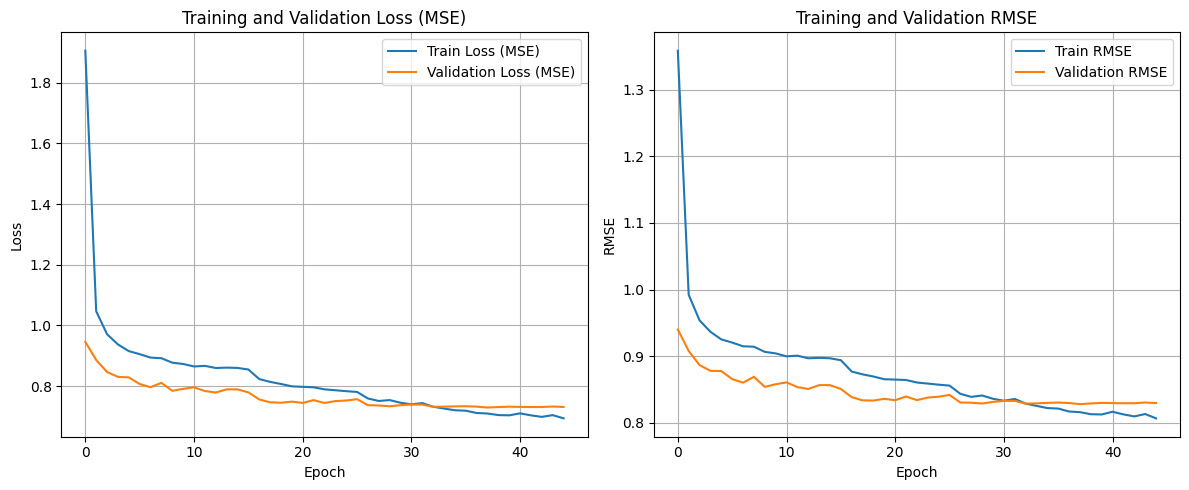

In [31]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss (MSE)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss (MSE)')
    plt.legend()
    plt.grid(True)

    # Plot training & validation RMSE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('Training and Validation RMSE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call this after training:
plot_training_history(history)


In [33]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Predict using the correct model
y_pred = model_finall.predict(X_test_tensor).flatten()
y_true = y_test_tensor.numpy().flatten()

# Check shapes (optional sanity check)
print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Test RMSE_3: {rmse:.4f}")
print(f"Test MAE_3: {mae:.4f}")
print(f"Test R²_3 Score: {r2:.4f}")
joblib.dump(y_test, "y_test.pkl")
joblib.dump(y_pred, "y_pred.pkl")

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
y_true shape: (20000,)
y_pred shape: (20000,)
Test RMSE_3: 0.8383
Test MAE_3: 0.6440
Test R²_3 Score: 0.6481


['y_pred.pkl']

In [29]:
model_finall.save("model_finall.keras")
 